In [0]:
# !wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip

In [0]:
# !unzip dogImages.zip

In [0]:
#  !rm dogImages.zip

In [0]:
# !wget http://vis-www.cs.umass.edu/lfw/lfw.tgz;

In [0]:
# !tar -xvzf lfw.tgz

In [0]:
# !rm lfw.tgz

In [9]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


Number of faces detected: 1


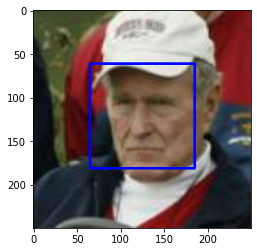

In [10]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [0]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [12]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]


print("humans: " + str(sum([face_detector(i) for i in human_files_short])))
print("dogs: "+str(sum([face_detector(i) for i in dog_files_short])))

humans: 100
dogs: 18


In [0]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

In [15]:
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained  corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    img=Image.open(img_path)
    normalize=transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])])
    img=normalize(img).float()
    img=img.unsqueeze(0)
    return VGG16(img.cuda())

In [0]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
d    pred = VGG16_predict(img_path).cpu().detach().numpy()
    return True if np.argmax(pred[0],axis=0) in range(151,269) else False # true/false

In [18]:
print("humans: " + str(sum([dog_detector(i) for i in human_files_short])))
print("dogs: "+str(sum([dog_detector(i) for i in dog_files_short])))

humans: 0
dogs: 95


In [0]:
import os
from torchvision import datasets

## Writing data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
train_transform=transforms.Compose([transforms.Resize(256),
                              transforms.RandomHorizontalFlip(), 
                              transforms.RandomResizedCrop(224,scale=(0.08,1),ratio=(1,1)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
                             ])
test_val_transform=transforms.Compose([transforms.Resize((224,224)),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485,0.456,0.406],
                               std=[0.229,0.224,0.225])
                             ])

train_data=datasets.ImageFolder("./dogImages/train/",transform=train_transform)
valid_data=datasets.ImageFolder("./dogImages/valid/",transform=test_val_transform)
test_data=datasets.ImageFolder("./dogImages/test/",transform=test_val_transform)

train_loader=torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=16)
valid_loader=torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=False)
test_loader=torch.utils.data.DataLoader(test_data)

loaders_scratch={'train':train_loader,
                 'valid':valid_loader,
                 'test' :test_loader}

In [0]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.pool=nn.MaxPool2d(2,2)
        self.fc1_1=nn.Conv2d(3,32,3,stride=1,padding=1)
        self.bn1_1=nn.BatchNorm2d(32)
        self.fc1_2=nn.Conv2d(32,32,3,stride=1,padding=1)
        self.bn1_2=nn.BatchNorm2d(32)
        

        self.fc2_1=nn.Conv2d(32,64,3,stride=1,padding=1)
        self.bn2_1=nn.BatchNorm2d(64)
        self.fc2_2=nn.Conv2d(64,64,3,stride=1,padding=1)
        self.bn2_2=nn.BatchNorm2d(64)
        self.pool2=nn.MaxPool2d(2,2)

        self.fc3_1=nn.Conv2d(64,128,3,stride=1,padding=1)
        self.bn3_1=nn.BatchNorm2d(128)
        self.fc3_2=nn.Conv2d(128,128,3,stride=1,padding=1)
        self.bn3_2=nn.BatchNorm2d(128)

        self.ln1_1=nn.Linear(128,133)


    def forward(self, x):
        x=F.relu(self.bn1_1(self.fc1_1(x)))
        x=F.relu(self.bn1_2(self.fc1_2(x)))
        x=self.pool(x)

        x=F.relu(self.bn2_1(self.fc2_1(x)))
        x=F.relu(self.bn2_2(self.fc2_2(x)))
        x=self.pool(x)

        x=F.relu(self.bn3_1(self.fc3_1(x)))
        x=F.relu(self.bn3_2(self.fc3_2(x)))
        x=self.pool(x)

        x=x.view(x.size(0),x.size(1),-1)

        x=x.max(2)[0]

        x=self.ln1_1(x)
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

In [0]:
import torch.optim as optim

import numpy as np
criterion_scratch = nn.CrossEntropyLoss()
learning_rate=5e-4*np.logspace(0,1.5,9)
learning_rate=learning_rate[2]
optimizer_scratch = optim.Adam(model_scratch.parameters(),lr=learning_rate)


In [0]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output=model(data)
            loss=criterion(output,target)
            train_loss+=loss.item()*data.size(0)
            loss.backward()
            optimizer.step()
        train_loss=train_loss/len(loaders['train'].dataset)

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output=model(data)
            loss=criterion(output,target)
            valid_loss+=loss.item()*data.size(0)
        valid_loss=valid_loss/len(loaders['valid'].dataset)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss<valid_loss_min:
          print("min validation loss: "+str(valid_loss) + "saving model")
          torch.save(model.state_dict(),save_path)
          valid_loss_min=valid_loss
    # return trained model
    return model

Epoch: 1 	Training Loss: 4.978577 	Validation Loss: 4.842527
min validation loss: 4.842526756218094saving model
Epoch: 2 	Training Loss: 4.737130 	Validation Loss: 4.780668
min validation loss: 4.780668413710451saving model
Epoch: 3 	Training Loss: 4.650283 	Validation Loss: 4.695343
min validation loss: 4.6953430124385624saving model
Epoch: 4 	Training Loss: 4.590457 	Validation Loss: 4.622039
min validation loss: 4.622038523165766saving model
Epoch: 5 	Training Loss: 4.534896 	Validation Loss: 4.597199
min validation loss: 4.597199112783649saving model
Epoch: 6 	Training Loss: 4.481097 	Validation Loss: 4.574714
min validation loss: 4.5747139336820135saving model
Epoch: 7 	Training Loss: 4.417440 	Validation Loss: 4.500541
min validation loss: 4.500540604848347saving model
Epoch: 8 	Training Loss: 4.349087 	Validation Loss: 4.500848
Epoch: 9 	Training Loss: 4.285328 	Validation Loss: 4.404645
min validation loss: 4.404645252227783saving model
Epoch: 10 	Training Loss: 4.214117 	Valid

In [0]:
# train the model
model_scratch = train(60, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# this training took like hours to run and i accidentaly deleted the output so had to paste it as text.

In [26]:
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

<All keys matched successfully>

In [27]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.519771


Test Accuracy: 38% (324/836)


In [0]:
## Specify data loaders
load_transfer=loaders_scratch

In [29]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
model_transfer=models.resnet50(pretrained=True)

for param in model_transfer.parameters():
  param.requires_grad=False

model_transfer.fc=nn.Linear(model_transfer.fc.in_features,133)
nn.init.kaiming_normal_(model_transfer.fc.weight, nonlinearity='relu')
if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [0]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(),learning_rate)


In [32]:
# train the model
model_transfer = train(50, load_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 2.769651 	Validation Loss: 1.075827
min validation loss: 1.0758268313493557saving model
Epoch: 2 	Training Loss: 1.226695 	Validation Loss: 0.755374
min validation loss: 0.7553740772658479saving model
Epoch: 3 	Training Loss: 0.995476 	Validation Loss: 0.643418
min validation loss: 0.643417876066562saving model
Epoch: 4 	Training Loss: 0.888568 	Validation Loss: 0.706755
Epoch: 5 	Training Loss: 0.782837 	Validation Loss: 0.564564
min validation loss: 0.5645638838499606saving model
Epoch: 6 	Training Loss: 0.780017 	Validation Loss: 0.590631
Epoch: 7 	Training Loss: 0.744831 	Validation Loss: 0.584313
Epoch: 8 	Training Loss: 0.705838 	Validation Loss: 0.611906
Epoch: 9 	Training Loss: 0.694288 	Validation Loss: 0.584107
Epoch: 10 	Training Loss: 0.665243 	Validation Loss: 0.586040
Epoch: 11 	Training Loss: 0.626615 	Validation Loss: 0.567692
Epoch: 12 	Training Loss: 0.638743 	Validation Loss: 0.578237
Epoch: 13 	Training Loss: 0.627451 	Validation Loss: 0.632

In [33]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [35]:
test(load_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.592308


Test Accuracy: 81% (681/836)


In [0]:
### function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
data={"train":train_data,
      "valid":valid_data,
      "test":test_data}
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data['train'].classes]

def predict_breed_transfer(img_path,model):
    # load the image and return the predicted breed
    img=Image.open(img_path)

    in_transform=transforms.Compose([
                  transforms.Resize((224,224)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485,0.456,0.406],
                                        std=[0.229,0.224,0.225])         
                ])
    img=in_transform(img).float().unsqueeze(0)
    print(img.shape)
    scores=model(img.cuda()).mean(0)
    output=torch.argmax(scores)
    return output.to("cpu").item(),F.softmax(scores,dim=0).to("cpu").data.numpy()


In [0]:
def show_image(img_path, title = None):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    if title is not None:
        plt.gca().set_title(title)
    plt.show()

torch.Size([1, 3, 224, 224])


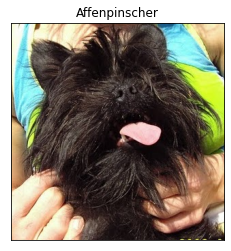

In [51]:
test_image=dog_files_short[0]
pred,probs=predict_breed_transfer(test_image,model_transfer)
show_image(test_image,title=class_names[pred])

In [0]:
def show_image_with_prob(img_path,picture,pie,breeds,probs):
  img=cv2.imread(img_path)
  if pie is None:
    fig,ax=plt.subplots(figsize=(10,5))
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(picture)
  else:
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(img)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title(picture)

    wedges,texts,autotexts=ax[1].pie(probs,autopct="%1.1f%%",wedgeprops={'linewidth':0})
    ax[1].axis('equal')
    ax[1].legend(wedges,breeds,title="Likely breeds",
                 loc="center left",bbox_to_anchor=(1,0,0.5,1))
    ax[1].set_title(pie)
  plt.show()

def process_prob(probs):
  threshold=0.01
  selected=probs>threshold
  top_4_idx = np.argsort(probs)[-4:]
  top_4_values = [probs[i] for i in top_4_idx]
  return top_4_idx,top_4_values



def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    dog_detect=dog_detector(img_path)
    hum_detect=face_detector(img_path)
    pred,probs=predict_breed_transfer(img_path,model_transfer)
    top_4_idx,top_4_values=process_prob(probs)
    top_4_breeds=[class_names[i] for i in top_4_idx]

    if len(top_4_values)>1:
      if sum(top_4_values)<0.99:
        top_4_values.append(1-sum(top_4_values))
        top_4_breeds.append("Others")
    if dog_detect and not hum_detect:
      picture=f"Omg dogi!\n {class_names[pred]}'s are so cute!!"
      if len(top_4_breeds)==1:
        pie="Wow a purebred!"
      else:
        pie="We have a mix here!"
    elif not dog_detect and hum_detect:
      picture=f"Hello puny human. A nice {class_names[pred]} you are"
      pie="You look like these breeds of dog"
    elif dog_detect and hum_detect:
      picture=f"Hello human and Dogi! Is that a {class_names[pred]} ?"
      if len(top_4_breeds)==1:
        pie="Wow a purebred!"
      else:
        pie="We have a mix here!"
    else:
      picture="nice pic deer. but no humans or dogs in it."
      pie=None

    show_image_with_prob(img_path=img_path,picture=picture,pie=pie,breeds=top_4_breeds,probs=top_4_values)





torch.Size([1, 3, 224, 224])


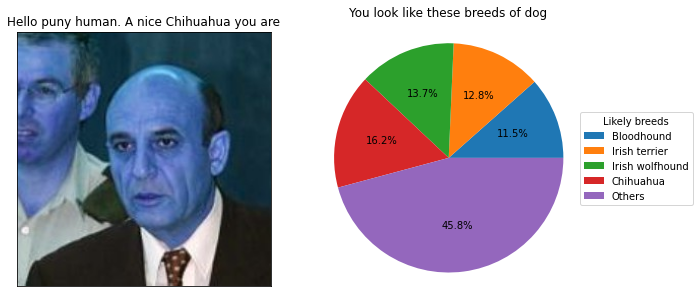

torch.Size([1, 3, 224, 224])


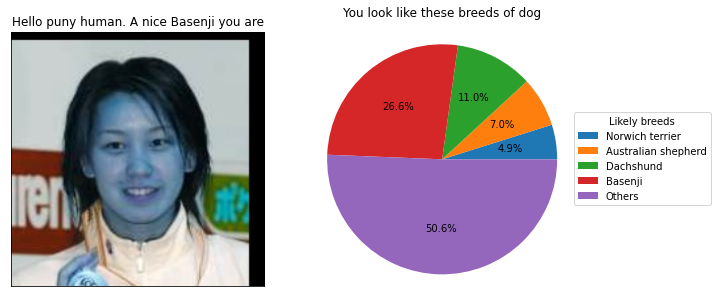

torch.Size([1, 3, 224, 224])


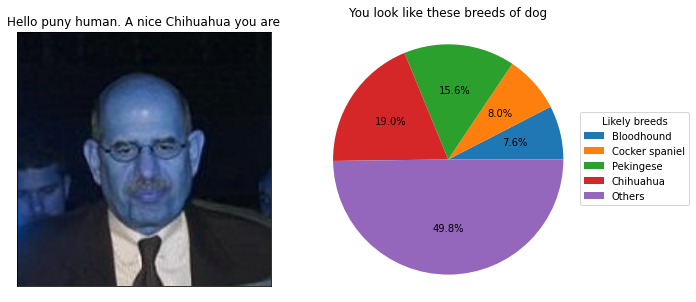

torch.Size([1, 3, 224, 224])


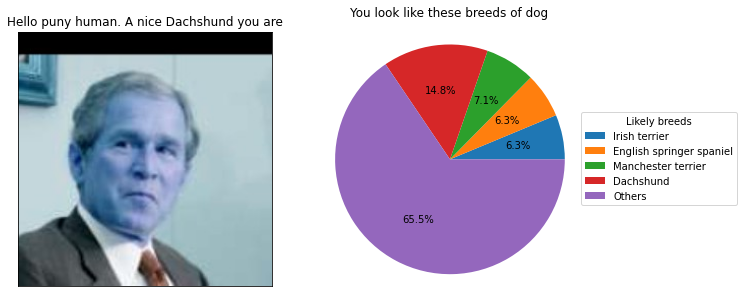

torch.Size([1, 3, 224, 224])


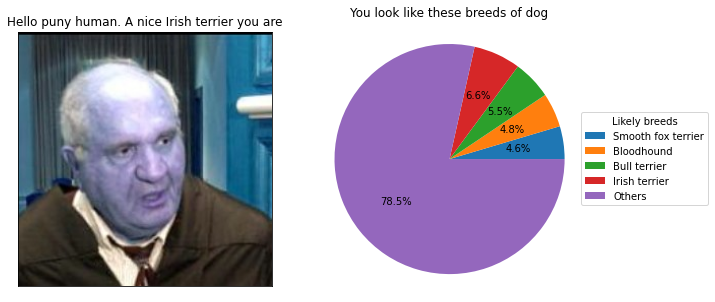

torch.Size([1, 3, 224, 224])


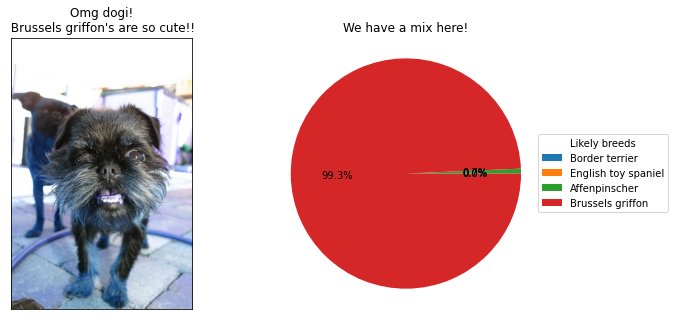

torch.Size([1, 3, 224, 224])


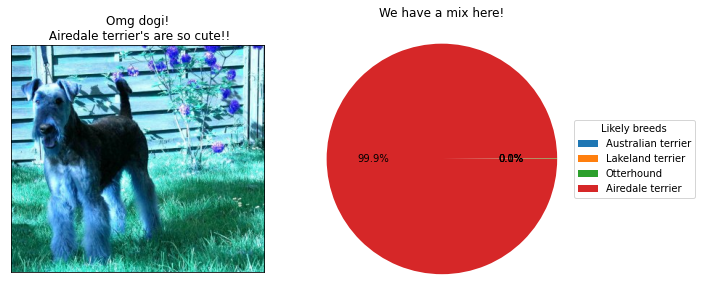

torch.Size([1, 3, 224, 224])


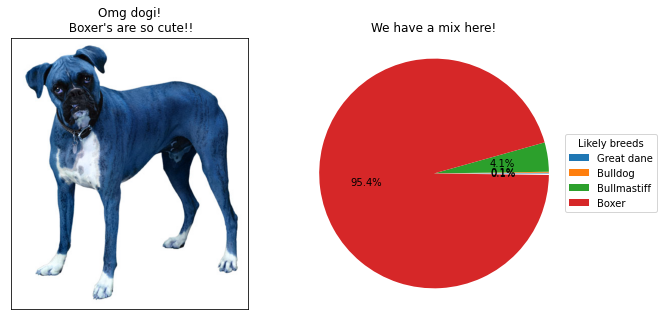

torch.Size([1, 3, 224, 224])


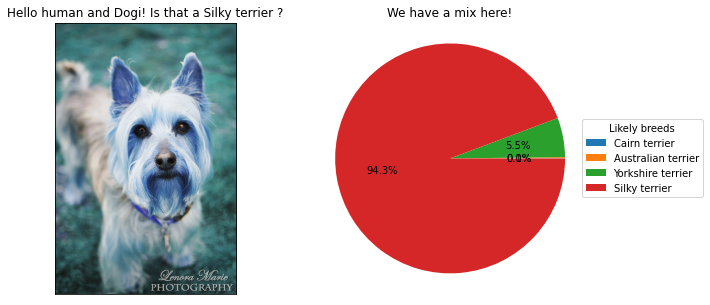

torch.Size([1, 3, 224, 224])


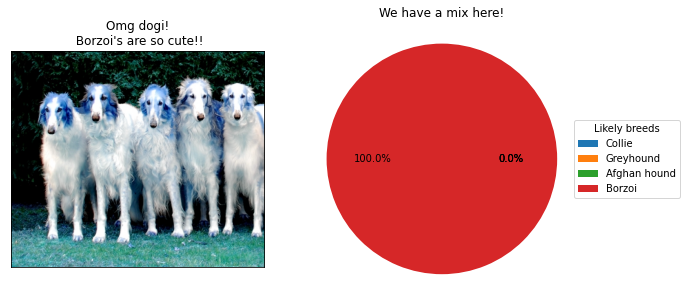

In [71]:
selection_human = np.random.randint(0,high=len(human_files),size=5)
selection_dogs = np.random.randint(0,high=len(dog_files),size=5)
for file in np.hstack((human_files[selection_human], dog_files[selection_dogs])):
    run_app(file)

torch.Size([1, 3, 224, 224])


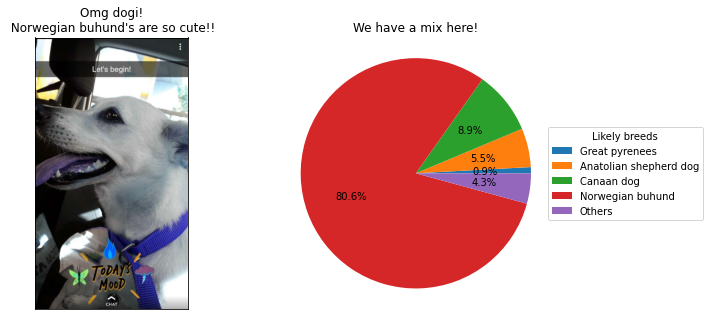

torch.Size([1, 3, 224, 224])


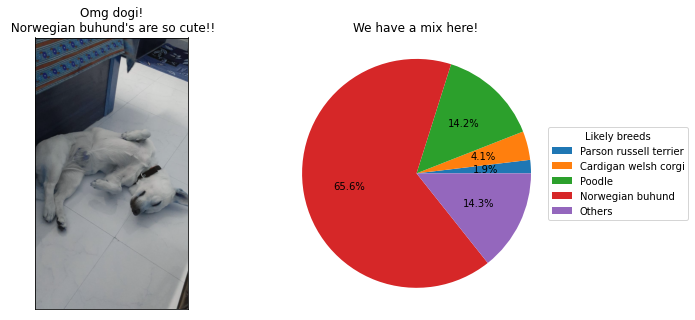

torch.Size([1, 3, 224, 224])


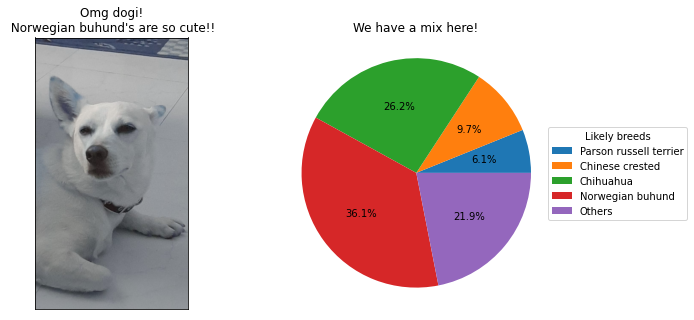

torch.Size([1, 3, 224, 224])


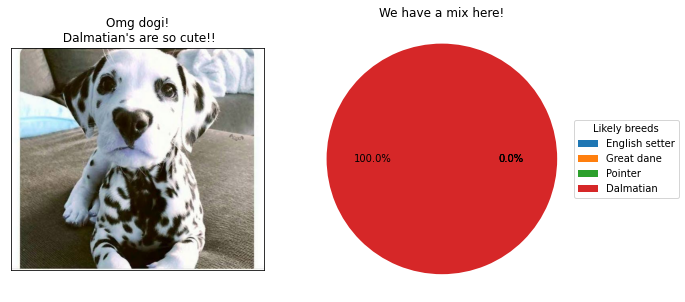

torch.Size([1, 3, 224, 224])


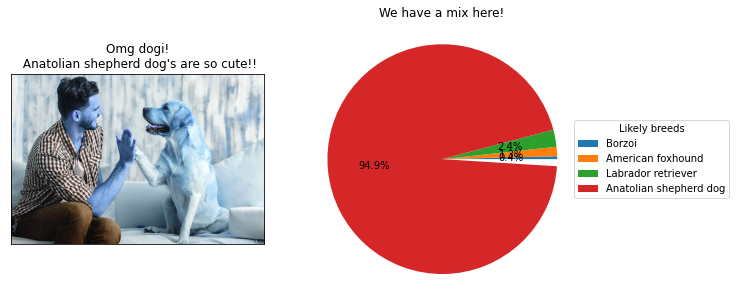

torch.Size([1, 3, 224, 224])


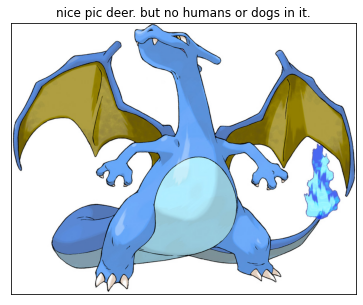

In [76]:

run_app("steffy1.jpeg")
run_app("steffy2.jpeg")
run_app("steffy3.jpeg")
run_app("random1.jpeg")
run_app("random2.jpg")
run_app("random3.jpg")